# Instalação

In [41]:
!pip install pgmpy

In [42]:
!pip install networkx

# Inferência Exata

## Estudo de caso: Rede Bayesiana para Sintomas

Seguindo o enunciado, as variáveis definidas para o caso a ser estudado são da forma:

Variável | Tipo | Valores
---      | ---  | ---
G | Binária | {+g, g}
A   | Binária | {+a, -a}
B    | Binária | {+b, -b}
S  | Binária | {+s, -s}




### Construção da Rede Bayesiana
Construindo uma Rede Bayesiana com as variáveis fornecidas no enunciado, com os nós definidos em ordem topológica:




In [43]:
from pgmpy.models import BayesianModel

symptom_model = BayesianModel([('G', 'A'), 
                               ('A', 'S'),
                               ('B', 'S')])

## Grafo Acíclico Dirigido (DAG)
Agora criando um Grafo Acíclico Dirigido para visualização da rede bayesiana:

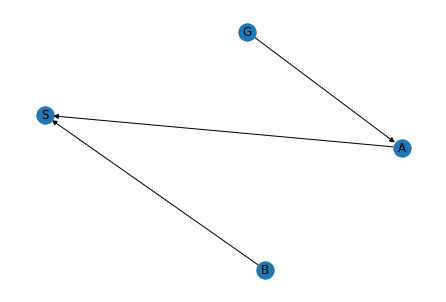

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(symptom_model, with_labels = True); 
plt.show()

## Distribuições de Probabilidade Condicional

Agora, vamos especificar as Distribuições de Probabilidade Condicional para as variáveis da rede, de acordo com os valores fornecidos no enunciado:

In [45]:
from pgmpy.factors.discrete import TabularCPD

cpd_G = TabularCPD( variable='G', 
                    variable_card=2,
                    values=[[0.1], [0.9]],
                    state_names={'G': ['+g', '-g']}
                  )

cpd_A = TabularCPD( variable='A', 
                    variable_card=2,
                    values=[[1.0, 0.1],
                            [0.0, 0.9]
                           ],
                    state_names={ 'A': ['+a', '-a'],
                                  'G': ['+g', '-g']                                          
                                },
                    evidence=['G'], 
                    evidence_card=[2]
                  )

cpd_B = TabularCPD( variable='B', 
                    variable_card=2,
                    values=[[0.4], [0.6]],
                    state_names={'B': ['+b', '-b']}
                  )

cpd_S = TabularCPD( variable='S', 
                    variable_card=2,
                    values=[[1.0, 0.9, 0.8, 0.1],
                            [0.0, 0.1, 0.2, 0.9]
                           ],
                    state_names={ 'S': ['+s', '-s'],
                                  'A': ['+a', '-a'],
                                  'B': ['+b', '-b'],
                                },
                    evidence=['A', 'B'], 
                    evidence_card=[2,2]
                   )

Adicionando cada CPD a sua variável correspondente no grafo da Rede Bayesiana:

In [46]:
symptom_model.add_cpds(cpd_G, cpd_A, cpd_B, cpd_S)

Verificando sintáticamente a rede bayesiana:

In [47]:
symptom_model.check_model()

True

## Realizando Inferências

Agora podemos realizar inferências sobre o modelo construído.

In [48]:
from pgmpy.inference import VariableElimination

In [49]:
symptom_infer = VariableElimination(symptom_model)

$\ i. Pr(+g, +a, +b, +s) = 0.04$





In [50]:
joint = symptom_infer.query(variables=['G', 'A', 'B', 'S'])
print(joint)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-------+-------+-------+-------+----------------+
| B     | G     | A     | S     |   phi(B,G,A,S) |
+=======+=======+=======+=======+================+
| B(+b) | G(+g) | A(+a) | S(+s) |         0.0400 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(+g) | A(+a) | S(-s) |         0.0000 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(+g) | A(-a) | S(+s) |         0.0000 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(+g) | A(-a) | S(-s) |         0.0000 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(-g) | A(+a) | S(+s) |         0.0360 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(-g) | A(+a) | S(-s) |         0.0000 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(-g) | A(-a) | S(+s) |         0.2592 |
+-------+-------+-------+-------+----------------+
| B(+b) | G(-g) | A(-a) | S(-s) |         0.0648 |
+-------+-------+-------+-------+----------------+
| B(-b) | G(+g) | A(+a) | S(+s)

 $\ ii. Pr(+a) = 0.19$

In [51]:
prob = symptom_infer.query(variables=['A'])
print(prob)

Eliminating: B: 100%|██████████| 3/3 [00:00<00:00, 349.46it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.1900 |
+-------+----------+
| A(-a) |   0.8100 |
+-------+----------+


$\ iii. Pr(+a \mid +b) = 0.19 $


As variáveis A e B são independentes, logo o valor da probabilidade é $P(A=+a)$

In [52]:
prob = symptom_infer.query(variables=['A'], evidence = {'B' : '+b'})
print(prob)

Eliminating: G: 100%|██████████| 2/2 [00:00<00:00, 338.15it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.1900 |
+-------+----------+
| A(-a) |   0.8100 |
+-------+----------+


$\ iv. Pr(+a \mid +s, +b) = 0.2267$


In [53]:
prob = symptom_infer.query(variables=['A'], evidence = {'S': '+s','B' : '+b'})
print(prob)

Eliminating: G: 100%|██████████| 1/1 [00:00<00:00, 93.49it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.2267 |
+-------+----------+
| A(-a) |   0.7733 |
+-------+----------+


$\ v. Pr(+g \mid +a) = 0.5263$


In [54]:
prob = symptom_infer.query(variables=['G'], evidence = {'A': '+a'})
print(prob)

Eliminating: B: 100%|██████████| 2/2 [00:00<00:00, 639.23it/s]

+-------+----------+
| G     |   phi(G) |
+=======+==========+
| G(+g) |   0.5263 |
+-------+----------+
| G(-g) |   0.4737 |
+-------+----------+


$\ vi.Pr(+g \mid +b) = 0.1 $


In [55]:
prob = symptom_infer.query(variables=['G'], evidence = {'B': '+b'})
print(prob)

Eliminating: A: 100%|██████████| 2/2 [00:00<00:00, 406.33it/s]

+-------+----------+
| G     |   phi(G) |
+=======+==========+
| G(+g) |   0.1000 |
+-------+----------+
| G(-g) |   0.9000 |
+-------+----------+


# Inferência Aproximada

## Estudo de caso: Rede Bayesiana para Grass Wet

Seguindo o enunciado, as variáveis definidas para o caso a ser estudado são da forma:

Variável | Tipo | Valores
---      | ---  | ---
Rain (R) | Booleana | {T, F}
Sprinler (S)| Booleana | {T, F}
Grass wet (G) | Booleana | {T, F}





## Construção da Rede Bayesiana
Construindo a rede bayesiana pedida no enunciado, com os nós definidos em ordem topológica:

In [56]:
grass_model = BayesianModel([ ('R', 'S'), 
                              ('R', 'G'),
                              ('S', 'G')])

## Grafo Acíclico Direcionado
Criando um Grafo Acíclico Direcionado para visualização:

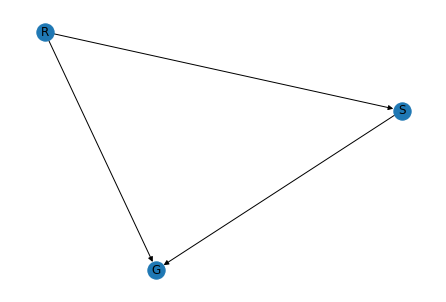

In [57]:
nx.draw(grass_model, with_labels = True); 
plt.show()

## Distribuições de Probabilidade Condicional
Especificando as Distribuições de Probabilidade Condicional para as variáveis da rede, de acordo com os valores fornecidos no enunciado:

In [58]:
cpd_R = TabularCPD( variable='R', 
                    variable_card=2,
                    values=[[0.2], [0.8]],
                    state_names={'R': ['T', 'F']}
                  )

cpd_S = TabularCPD( variable='S', 
                    variable_card=2,
                    values=[[0.01, 0.4],
                            [0.99, 0.6]
                           ],
                    state_names={'S': ['T', 'F'],
                                 'R': ['T', 'F']
                                },
                    evidence=['R'],
                    evidence_card=[2]
                  )

cpd_G = TabularCPD( variable='G', 
                    variable_card=2,
                    values=[[0.01, 0.01, 0.01, 0.4],
                            [0.99, 0.99, 0.99, 0.6]
                           ],
                    state_names={ 'G': ['T', 'F'],
                                  'S': ['T', 'F'],
                                  'R': ['T', 'F'],
                                },
                    evidence=['S', 'R'], 
                    evidence_card=[2,2]
                   )

Adicionando cada CPD a sua variável correspondente no grafo da Rede Bayesiana:

In [59]:
grass_model.add_cpds(cpd_R, cpd_S, cpd_G)

Verificando sintáticamente a rede bayesiana:

In [60]:
grass_model.check_model()

True

## Implementação de Algoritmos

Para a implementação dos métodos de amostragem na rede bayesiana, usaremos a função auxiliar abaixo, que tem como objetivo realizar uma dada variável da rede bayesiana considerando sua cpd e os valores dos nós pais para a variável, caso existam:

In [61]:
import numpy as np

def realize_variable(bayesian_model, variable_name, parents):
  """
    Gera um valor para uma variável da rede bayesiana, de acordo com sua cpd 
    e os valores dos nós pais para essa variável, caso existam.
  """
  cpd_table = bayesian_model.get_cpds(variable_name)
  variables_in_cpd = cpd_table.variables
  cpd = cpd_table

  if parents:
    # Verifica se existem nós pais para a variável.
    conditioners = []
    for key, value in parents.items():
      if key == variable_name:
        continue
      if key not in variables_in_cpd:
        continue
      conditioners.append((key, value))
    cpd = cpd_table.reduce(conditioners, inplace  = False)
  
  state_names_dict = bayesian_model.get_cpds(variable_name).state_names

  values = state_names_dict[variable_name]
  probs = cpd.get_values()

  # Gera um valor para a variável.
  cum_sum = np.cumsum(probs)
  s = np.random.uniform(0,1)
  for j in range(cum_sum.shape[0]):
    if s < cum_sum[j]:
      return values[j]

### Amostragem a Priori

Agora implementando o algoritmo do método de Amostragem a Priori, utilizando a assinatura fornecida no enuncaido do trabalho:

In [62]:
def amostragem_a_priori(rede_bayesiana, q, obs, num_amostras):
  """
    Faz a coleta de amostras utilizando o método de Amostragem a Priori e
    retorna uma aproximação para os valores possíveis da variável q na consulta
    P(q | obs)
  """

  q_probs = dict() # Retorno da função, um dicionario com elementos (k,v) 
                   # onde k é um valor possível da variável q,
                   # e v é a probabilidade aproximada desse valor ocorrer 
                   # computada pela função.

  samples = dict() # Dicionário para armazenar as amostras colhidas.
                   # Seus elementos são da forma (k,v), em que k é o indíce
                   # da amostra colhida, e v é a própria amostra.
                   # Ex: {1: {Rain: 'T', Sprinkler: 'F, Wet: 'T' }}

  n_samples_evidence_true = 0 # Variável auxiliar para armazenar o número
                              # de amostras em que a evidência obs acontece.

  q_values = [] # Lista auxiliar para armazenar todos os valores de q nas 
                # amostras em que obs acontece.
  
  variables = grass_model.nodes()

  for i in range(1, num_amostras+1):
    # Coleta de amostras seguindo a ordem topológica da rede bayesiana.

    parents = dict() # Armazena o valor dos nós pais da variável atual sendo 
                     # amostrada e é incrementado de forma que ao final do loop
                     # equivalha à própria amostra.
    sample = dict()

    for v in variables:
      parents[v] = realize_variable(rede_bayesiana, v, parents) 
      sample = parents
    samples[i] = sample

  for sample in samples.values():
    # Consulta com base nas amostras colhidas.
    
    if obs:
      # Caso obs exista, verifica se obs está contido em cada amostra.
      # obs_is_subset_of_sample retorna True se obs está contido em sample.
      obs_is_subset_of_sample = all(sample.get(key, None) == value for key, value in obs.items())
      if obs_is_subset_of_sample:
        # Se a amostra contém a evidência, adiciona o valor da chave q na lista 
        # q_values.
        n_samples_evidence_true += 1
        q_values.append(sample[q])
    else:
      # Caso obs não exista, adiciona todos os valores das chaves q na lista 
      # q_values.
      n_samples_evidence_true = num_amostras
      q_values.append(sample[q])
    
  # Armazena a quantidade de ocorrências para cada possível valor de q e
  # obtém a probabilidade fazendo a divisão por n_sample_evidence_true.
  q_probs = {i: (q_values.count(i)/n_samples_evidence_true) for i in q_values}

  #print("Amostras:\n", samples)
  print('Valor aproximado para a consulta: ')
  return q_probs




#### Realizando Inferências

Agora realizando as consultas pedidas pelo enunciado usando Amostragem a Priori:


$\ i. Pr(R) $

Como não existe evidência, passamos o parâmetro obs como None para a função.




*   **Para 5 amostras:**







In [99]:
amostragem_a_priori(grass_model, 'R', None, 5)

Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [64]:
amostragem_a_priori(grass_model, 'R', None, 50)

Valor aproximado para a consulta: 


{'F': 0.88, 'T': 0.12}

*   **Para 500 amostras**:







In [65]:
amostragem_a_priori(grass_model, 'R', None, 500)

Valor aproximado para a consulta: 


{'F': 0.818, 'T': 0.182}

$\ ii. Pr(S) $




*   **Para 5 amostras:**







In [98]:
amostragem_a_priori(grass_model, 'S', None, 5)

Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [67]:
amostragem_a_priori(grass_model, 'S', None, 50)

Valor aproximado para a consulta: 


{'F': 0.64, 'T': 0.36}

*   **Para 500 amostras:**







In [68]:
amostragem_a_priori(grass_model, 'S', None, 500)

Valor aproximado para a consulta: 


{'F': 0.682, 'T': 0.318}

$\ iii. Pr(G) $




*   **Para 5 amostras:**







In [69]:
amostragem_a_priori(grass_model, 'G', None, 5)

Valor aproximado para a consulta: 


{'F': 1.0}

*   **Para 50 amostras:**







In [70]:
amostragem_a_priori(grass_model, 'G', None, 50)

Valor aproximado para a consulta: 


{'F': 0.76, 'T': 0.24}

*   **Para 500 amostras:**







In [71]:
amostragem_a_priori(grass_model, 'G', None, 500)

Valor aproximado para a consulta: 


{'F': 0.792, 'T': 0.208}

$\ iv. Pr(G \mid S = True) $

Agora passamos um parâmetro para obs.




*   **Para 5 amostras:**







In [72]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 1.0}

*   **Para 50 amostras:**







In [73]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 0.9230769230769231, 'T': 0.07692307692307693}

*   **Para 500 amostras:**







In [74]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 1.0}

 $\ v. Pr(G \mid S = False) $




*   **Para 5 amostras:**







In [75]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 0.5, 'T': 0.5}

*   **Para 50 amostras:**







In [76]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 0.7941176470588235, 'T': 0.20588235294117646}

*   **Para 500 amostras:**







In [77]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 0.717201166180758, 'T': 0.282798833819242}

### Ponderação por Verossimilhança

Para a Ponderação por Verossimilhança, em determinado momento precisaremos obter o valor do resultado da seguinte probabilidade: 

$$ Pr(X1 = x1 \mid Parents(X1)) $$

O método reduce do pgmpy retorna apenas a tabela de valores possíveis para a consulta $\ Pr(X1 \mid Parents(X1))$, sendo necessária realizar a consulta do valor de X1 desejado na tabela. Para obter diretamente o valor de X1 desejado, usaremos a função abaixo:

In [78]:
def get_conditional_probability(rede_bayesiana, variable_name, variable_value, parents):
  """
    Calcula Pr(Xi = xi | Parents(Xi)), retorna o valor obtido.

    rede_bayesiana: Objeto BayesianModel do pgmpy.
    variable_name: Nome da variável a ser consultada.
    variable_value: Valor desejado para a variável a ser consultada.
    parents: Dicionário {k1:v1, k2:v2, ... } com os nomes e valores dos nós 
             pais da variável.
  """
  formatted_parents = [] 
  # É preciso formatar o parâmetro parents, que possui um formato de dicionário
  # {k1 : v1, k2: v2,...} para uma lista da forma [(k1, v1), (k2, v2),...]
  # Assim conseguimos usar esse resultado no método reduce.
  for key, value in parents.items():
    formatted_parents.append((key,value))

  # Obtemos a cpd condicionada.
  cpd_table = rede_bayesiana.get_cpds(variable_name)
  cpd = cpd_table.reduce(formatted_parents, inplace  = False)

  # Realizamos algumas operações e formatações com os métodos do pgmpy para 
  # obter o valor numérico da probabilidade desejada.
  state_names = list(cpd.state_names.values())[0]
  q_value_index = state_names.index(variable_value)

  prob_in_list_format = cpd.get_values()[q_value_index]
  prob = prob_in_list_format[0]
  return prob

Podemos testar a função para o modelo que estamos trabalhando com a consulta abaixo:

 $\ Pr(G = T \mid S = T, R = F)$

In [79]:
obs = dict()
obs['R'] = 'F'
obs['S'] = 'T'
get_conditional_probability(grass_model, 'G', 'T', obs )

0.01

Consultando a tabela de probabilidades para a variável G, vemos que o resultado está correto.

Agora implementando o método da Ponderação por Verossimilhança:

In [80]:
def ponderacao_por_verossimilhanca(rede_bayesiana, q, obs, num_amostras):
  """
    Faz a coleta de amostras utilizando o método de Ponderação por 
    Verossimilhança e retorna uma aproximação para os valores possíveis da 
    variável q na consulta P(q | obs)
  """
  variables = rede_bayesiana.nodes()
  
  q_probs = dict() # Retorno da função, um dicionario com elementos {k:v} 
                   # onde k é um valor possível da variável q,
                   # e v é a probabilidade aproximada desse valor ocorrer 
                   # computada pela função.

  q_weight_sums = dict() # Dicionário auxiliar da forma {k:v} onde k é um valor
                         # possível da variável q e v é a soma de seus pesos 
                         # computados.

  q_state_names = rede_bayesiana.get_cpds(q).state_names
  q_possible_values = q_state_names[q]
  for possible_value in q_possible_values:
    # Inicializa q_weight_sums com o valor de 0 para cada soma de pesos.
    q_weight_sums[possible_value] = 0

  total_weight_sum = 0 # Soma total do peso de todas as amostras.

  samples = dict() # Dicionário para armazenar as amostras colhidas. Possui
                   # a forma {k, v}, em que k é o índice da amostra e v é uma
                   # tupla (s , w) em que s é a própria amostra e w é seu peso.
                   # Ex: {1: ({'A': 'False', 'B': 'False', 'C': 'True'}, 0.4)} 

  evidence_variables = dict()
  if obs:
    evidence_variables = obs
   
  for i in range(1, num_amostras+1):
    # Coleta de amostras.
    weight = 1
    parents = dict() 
    for v in variables:
      if evidence_variables:
        if v in evidence_variables.keys():
          # Se a variável é evidência, fixar seu valor na amostra e multiplicar 
          # sua probabilidade condicionada na variável weight.
          v_value = evidence_variables[v]
          prob = get_conditional_probability(rede_bayesiana, v, v_value, parents)
          weight *= prob
          parents[v] = evidence_variables[v]
        else:
          # Se a variável não é evidência, obter um valor aleatório a partir de 
          # sua cpd e seus nós pais.
          parents[v] = realize_variable(rede_bayesiana, v, parents)
      else:
          # Caso não exista evidência, recair num caso semelhante ao da 
          # Amostragem a Priori
         parents[v] = realize_variable(rede_bayesiana, v, parents)
      samples[i] = parents, weight
    
    # Soma o peso da amostra atual em sua chave correspondente em 
    # q_weight_sums, dependendo do valor de q obtido na amostra atual. 
    sample = samples[i][0]
    sample_weight = samples[i][1]
    q_value_sample = sample[q]
    q_weight_sums[q_value_sample] += sample_weight
  
  for value in q_weight_sums.values():
    # Obtém a soma total dos pesos.
    total_weight_sum += value
  
  for key, value in q_weight_sums.items():
    # Normaliza e obtém as probabilidades para cada valor possível de q.
    q_probs[key] = value / total_weight_sum

  #print("Amostras:\n", samples)
  print('Valor aproximado para a consulta: ')
  return q_probs

#### Realizando Inferências

Usaremos o método de Ponderação por Verossimilhança para realizar as inferências aproximadas desejadas

$\ i. Pr(R) $




*   **Para 5 amostras:**







In [81]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 5)

Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [82]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 50)

Valor aproximado para a consulta: 


{'F': 0.8, 'T': 0.2}

*   **Para 500 amostras**:







In [83]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 500)

Valor aproximado para a consulta: 


{'F': 0.824, 'T': 0.176}

$\ ii. Pr(S) $




*   **Para 5 amostras:**







In [84]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 5)

Valor aproximado para a consulta: 


{'F': 0.4, 'T': 0.6}

*   **Para 50 amostras:**







In [85]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 50)

Valor aproximado para a consulta: 


{'F': 0.74, 'T': 0.26}

*   **Para 500 amostras:**







In [86]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 500)

Valor aproximado para a consulta: 


{'F': 0.722, 'T': 0.278}

$\ iii. Pr(G) $




*   **Para 5 amostras:**







In [87]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 5)

Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [88]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 50)

Valor aproximado para a consulta: 


{'F': 0.78, 'T': 0.22}

*   **Para 500 amostras:**







In [89]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 500)

Valor aproximado para a consulta: 


{'F': 0.736, 'T': 0.264}

$\ iv. Pr(G \mid S = True) $

Agora passamos um parâmetro para obs.




*   **Para 5 amostras:**







In [90]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 1.0, 'T': 0.0}

*   **Para 50 amostras:**







In [91]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 0.9717314487632509, 'T': 0.028268551236749106}

*   **Para 500 amostras:**







In [92]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 0.9950068655598552, 'T': 0.004993134440144763}

 $\ v. Pr(G \mid S = False) $




*   **Para 5 amostras:**







In [93]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 0.4690265486725664, 'T': 0.5309734513274337}

*   **Para 50 amostras:**







In [94]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 0.8230088495575222, 'T': 0.1769911504424778}

*   **Para 500 amostras:**







In [95]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 0.6994296916770629, 'T': 0.300570308322937}

### Conclusão

Analisando os resultados obtidos pelas consultas realizadas através dos dois métodos, percebebemos que na maior parte dos casos, quanto maior o número de amostras analisadas, mais acurada a aproximação para os valores de probabilidade se torna. Esse é um resultado esperado, que está de acordo com a Lei dos Grandes Números e seria mais facilmente observado se trabalhássemos com amostras de tamanhos ainda maiores que 500.

Apesar de não ter sido notada uma diferença grande nos resultados entre os dois métodos de amostragem para os números de amostras utilizados, percebemos que o método de Amostragem a Priori requer mais computação, pelo fato de ser necessária realizar a filtragem das amostras totais para obter as amostras em que a evidência ocorre.

